In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2


In [4]:
df_train = pd.read_csv("C:/Users/Ajaykumar/Downloads/senti(11)/twitter_training.csv")
df_test = pd.read_csv("C:/Users/Ajaykumar/Downloads/senti(11)/twitter_validation.csv")

In [5]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [7]:
df_test.columns = ['Header1', 'company','labels','text']
df_train.columns = ['Header1', 'company','labels','text']

In [8]:
df_train.head()

,Header1,company,labels,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [10]:
df_train.shape


(74681, 4)

In [11]:
df_test.shape

(999, 4)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Header1  74681 non-null  int64 
 1   company  74681 non-null  object
 2   labels   74681 non-null  object
 3   text     73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Header1  999 non-null    int64 
 1   company  999 non-null    object
 2   labels   999 non-null    object
 3   text     999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [14]:
df_train.duplicated().sum()

2700

In [15]:
df_test.duplicated().sum()

0

In [16]:
df_train.isnull().sum()

Header1      0
company      0
labels       0
text       686
dtype: int64

In [17]:
df_test.isnull().sum()

Header1    0
company    0
labels     0
text       0
dtype: int64

In [18]:
df_train.dropna(inplace=True)

In [19]:
df_train.isnull().sum()

Header1    0
company    0
labels     0
text       0
dtype: int64

In [21]:
df_train.drop_duplicates(inplace=True)

In [22]:
df_train.duplicated().sum()

0

In [23]:
df_train.drop(columns=['Header1', 'company'], inplace=True)
df_test.drop(columns=['Header1', 'company'], inplace=True)


In [24]:
df_train

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [25]:
df_test

,labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [26]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [27]:
df_train['text'] = df_train['text'].apply(clean_tweet)

# Clean the test data
df_test['text'] = df_test['text'].apply(clean_tweet)

In [28]:
df_train.head()

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [29]:
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [30]:
# Drop rows where 'OriginalTweet' is empty
df_train = df_train.dropna(subset=['text'])
df_test = df_test.dropna(subset=['text'])

# Alternatively, if there are rows with just whitespace, use this to remove them as well:
df_train = df_train[df_train['text'].str.strip() != '']
df_test = df_test[df_test['text'].str.strip() != '']

# Display the updated dataframe
df_train.head()

,labels,text
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [31]:
df_train.duplicated().sum()

4661

In [32]:
df_train = df_train.drop_duplicates(subset=['text'])

In [33]:
df_train.shape

(66387, 2)

In [35]:
# Separate features and labels for training data
train_texts = df_train['text'].values
train_labels = df_train['labels'].values

# Separate features and labels for test data
test_texts = df_test['text'].values
test_labels = df_test['labels'].values

In [36]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [37]:
# Initialize the tokenizer
tokenizer = Tokenizer()  # You can adjust the number of words

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [38]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [39]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 166


In [40]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [47]:
tokenizer = Tokenizer(num_words=input_size, oov_token="<OOV>")


In [48]:
print(f"Max token index in test data: {np.max(test_padded)}")


Max token index in test data: 29793


In [51]:
input_size = np.max(test_padded) + 1 # Adjust input size based on both train and test data
input_size

29794

In [52]:
embedding_dim = 100  # Example embedding dimension
max_length = 100  # Example max length
# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(56,)))

# Add a bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.1), return_sequences=True, recurrent_regularizer=l2(0.1))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# Add batch normalization layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 5 units for 5 labels and softmax activation
model.add(Dense(5, activation='softmax'))

In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 56, 100)             │       2,979,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 56, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,388,365 (12.93 MB)

 Trainable params: 3,387,597 (12.92 MB)

 Non-trainable params: 768 (3.00 KB)

In [54]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [55]:
history = model.fit(
    train_padded,
    train_labels_encoded ,
    validation_data=(test_padded,test_labels_encoded),
    epochs=10
)

Epoch 1/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 529s 247ms/step - accuracy: 0.4249 - loss: 8.8086 - val_accuracy: 0.7638 - val_loss: 0.7359
Epoch 2/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 518s 249ms/step - accuracy: 0.7826 - loss: 0.7203 - val_accuracy: 0.6967 - val_loss: 0.9074
Epoch 3/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 555s 268ms/step - accuracy: 0.8393 - loss: 0.5723 - val_accuracy: 0.8659 - val_loss: 0.4895
Epoch 4/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 569s 274ms/step - accuracy: 0.8675 - loss: 0.4943 - val_accuracy: 0.8759 - val_loss: 0.4639
Epoch 5/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 577s 278ms/step - accuracy: 0.8868 - loss: 0.4292 - val_accuracy: 0.7938 - val_loss: 0.6991
Epoch 6/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 676s 326ms/step - accuracy: 0.8993 - loss: 0.3947 - val_accuracy: 0.8388 - val_loss: 0.5669
Epoch 7/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 506s 244ms/step - accuracy: 0.9055 - loss: 0.3713 - val_accuracy: 0.9309 - val_loss: 0.2995
Epoch 8/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 326s 157ms/step - ac

In [56]:
test_loss, test_accuracy = model.evaluate(test_padded , test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9191 - loss: 0.3437
Test Loss: 0.3742005228996277
Test Accuracy: 0.9089089035987854


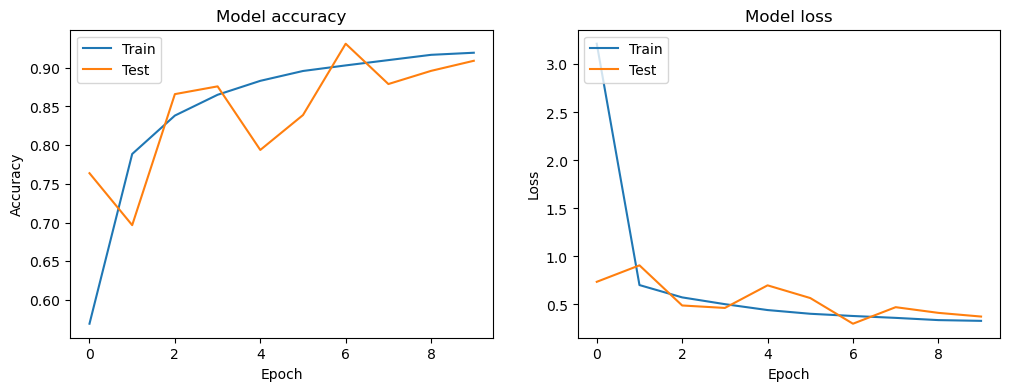

In [57]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()